**In this notebook, we implemented a personalized outfit recommendation system for H&M using transaction, article, and customer data. Our approach focused on building a simple yet effective popularity-based recommender that was enhanced by introducing budget awareness. Since real prices were not provided, we assigned mock prices and estimated each customer's budget based on age. Recommendations were generated by selecting the most popular articles that fall within ±20% of a customer’s estimated budget. To evaluate performance, we used MAP@12, along with Precision, Recall, and F1 score, ensuring a well-rounded understanding of our model’s accuracy. We also visualized the predicted articles with real images from the dataset to enable intuitive evaluation. This model is interpretable, scalable, and provides a solid foundation for future integration of deep learning or rank-based architectures.**

In [1]:
import pandas as pd
import numpy as np
import warnings
import gc
from tqdm import tqdm
from datetime import datetime

In [2]:
warnings.filterwarnings('ignore')
tqdm.pandas()

# Do customers buy items they bought before?
The source of this idea is these Notebook:
1. https://www.kaggle.com/code/hervind/h-m-faster-trending-products-weekly/notebook
2. https://www.kaggle.com/code/lichtlab/do-customers-buy-the-same-products-again

The code begins by loading transaction data containing purchase history (customer IDs, article IDs, and purchase dates). It converts the date column to datetime format and identifies the last day in the dataset.


In [3]:
%%time
transactions_train = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv', 
                                 usecols = ['t_dat', 'customer_id', 'article_id'], dtype={'article_id': str})
transactions_train['t_dat'] = pd.to_datetime(transactions_train['t_dat'])
lastday = transactions_train['t_dat'].max()
transactions_train

CPU times: user 34.4 s, sys: 5.19 s, total: 39.6 s
Wall time: 1min 12s


,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004
...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002


This section calculates the last day of the business week for each transaction and aggregates weekly sales. It helps understand weekly sales patterns for each article.


In [4]:
%%time
transactions_train['dow'] = transactions_train['t_dat'].dt.dayofweek
transactions_train['ldbw'] = transactions_train['t_dat'] - pd.TimedeltaIndex(transactions_train['dow'] - 1, unit='D')
transactions_train.loc[transactions_train['dow'] >=2 , 'ldbw'] = \
                transactions_train.loc[transactions_train['dow'] >=2 , 'ldbw'] + \
                pd.TimedeltaIndex(np.ones(len(transactions_train.loc[transactions_train['dow'] >=2])) * 7, unit='D')
del transactions_train['dow']
transactions_train

CPU times: user 6.71 s, sys: 1.67 s, total: 8.38 s
Wall time: 8.16 s


,t_dat,customer_id,article_id,ldbw
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,2018-09-25
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,2018-09-25
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,2018-09-25
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,2018-09-25
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,2018-09-25
...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,2020-09-22
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,2020-09-22
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,2020-09-22
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,2020-09-22


The code calculates how many times each article was purchased in each week, then creates a "quotient" feature comparing recent sales to past sales, which helps identify trending items.

In [5]:
%%time
weekly_sales = transactions_train.drop(['customer_id'], axis=1).groupby(['ldbw', 'article_id']).count()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
transactions_train = pd.merge(transactions_train, weekly_sales, on=['ldbw', 'article_id'], how='left')
transactions_train

CPU times: user 14.5 s, sys: 2.75 s, total: 17.2 s
Wall time: 17.2 s


,t_dat,customer_id,article_id,ldbw,count
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,2018-09-25,40
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,2018-09-25,29
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,2018-09-25,15
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,2018-09-25,1184
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,2018-09-25,1094
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,2020-09-22,64
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,2020-09-22,36
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,2020-09-22,6
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,2020-09-22,12


In [6]:
%%time
weekly_sales = weekly_sales.reset_index().set_index('article_id')
last_day = lastday.strftime('%Y-%m-%d')

transactions_train = transactions_train.join(
    weekly_sales.loc[weekly_sales['ldbw']==last_day, ['count']],
    on='article_id', rsuffix="_targ")

transactions_train['count_targ'].fillna(0, inplace=True)
# The count_targ column is to check the number of products sold in the past week, 
# and NAN means that the product has not been sold in this week
transactions_train

CPU times: user 6.34 s, sys: 1.3 s, total: 7.64 s
Wall time: 7.62 s


,t_dat,customer_id,article_id,ldbw,count,count_targ
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,2018-09-25,40,0.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,2018-09-25,29,0.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,2018-09-25,15,0.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,2018-09-25,1184,0.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,2018-09-25,1094,0.0
...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,2020-09-22,64,64.0
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,2020-09-22,36,36.0
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,2020-09-22,6,6.0
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,2020-09-22,12,12.0


**quotient** can be understood as the popularity of hot-selling products of the last week in each week

This section calculates how recently items were purchased and applies a time decay function. Products purchased more recently get higher weights (the 'value' metric), following the intuition that recent purchases are more indicative of current preferences.

In [7]:
transactions_train['quotient'] = transactions_train['count_targ'] / transactions_train['count']
transactions_train

,t_dat,customer_id,article_id,ldbw,count,count_targ,quotient
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,2018-09-25,40,0.0,0.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,2018-09-25,29,0.0,0.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,2018-09-25,15,0.0,0.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,2018-09-25,1184,0.0,0.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,2018-09-25,1094,0.0,0.0
...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,2020-09-22,64,64.0,1.0
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,2020-09-22,36,36.0,1.0
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,2020-09-22,6,6.0,1.0
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,2020-09-22,12,12.0,1.0


**value** can be understood as the consumer's liking for a certain product, which includes many factors (purchase time, number of purchases, and the popularity of the product (quotient))

In [8]:
%%time
train_fo = transactions_train.copy()
train_fo['week_x'] = ((lastday - train_fo['ldbw']) / np.timedelta64(7, 'D')).astype(int)
train_fo['sup_1'] = 0.1 
train_fo['week_x'] = train_fo[['week_x', 'sup_1']].max(axis=1)

train_fo['y'] = 1.2e3 / train_fo['week_x']
train_fo['sup_25'] = 25 
train_fo['y'] = train_fo[["y", "sup_25"]].max(axis=1)
train_fo['value'] = train_fo['quotient'] * train_fo['y'] 

value = train_fo.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
value = value.reset_index()
value

CPU times: user 37.5 s, sys: 9.05 s, total: 46.6 s
Wall time: 46.3 s


,customer_id,article_id,value
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,4.411765
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,55.000000
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043,819.512195
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0607642008,0.316456
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.000000
...,...,...,...
27306434,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0821395003,4.054054
27306435,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0840360003,0.628601
27306436,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0866755002,2.917399
27306437,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0882810001,67.132867


In [9]:
%%time
train_fo = train_fo.groupby(['customer_id', 'article_id']).agg({'value': 'sum'})
train_fo = train_fo.reset_index()

train_fo = train_fo.loc[train_fo['value'] > 180]
# why 180? If an item's quotient remains at 1, users will buy it again if it has been purchased about the last 7 weeks
train_fo['rank'] = train_fo.groupby("customer_id")["value"].rank("dense", ascending=False)
train_fo = train_fo.loc[train_fo['rank'] <= 12]

purchase_records = train_fo.sort_values(['customer_id', 'value'], ascending = False).reset_index(drop = True)
purchase_records['prediction'] = purchase_records['article_id'].astype(str) + ' '
purchase_records = purchase_records.groupby('customer_id').agg({'prediction': sum}).reset_index() #str求和
purchase_records['prediction'] = purchase_records['prediction'].str.strip()
purchase_records

CPU times: user 39.2 s, sys: 6.9 s, total: 46.1 s
Wall time: 46 s


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0719530003 0448509014
3,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0891899004 0797892001 0730863005 0904736002 05...
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,0807244012 0706016038 0914441005 0706016015 07...
...,...,...
339846,ffff11185bb6dc52d546424a28657dcb3c891b1f57e27b...,0685814003
339847,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,0871664001 0720504002 0399256001
339848,ffff2f5a160e334d722d2f2c36be9907f6d097a141e49b...,0654590001
339849,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0804992033 0720125039 0713997002 0557599022 07...


**pairing these items**

the idea from the notebook: https://www.kaggle.com/code/titericz/article-id-pairs-in-3s-using-cudf

This function analyzes which articles are frequently purchased together. It identifies item pairs with high co-occurrence, which can be used for "customers who bought X also bought Y" type recommendations.

In [10]:
def calc_pairs(train):
    # Calculate all articles purchased together
    dt = train.groupby(['customer_id','t_dat'])['article_id'].agg(list).rename('pair').reset_index()
    df = pd.merge(train[['customer_id', 't_dat', 'article_id']], dt, on=['customer_id', 't_dat'], how='left')
    del dt
    gc.collect()

    # baes_count
    base_count = df.groupby(['article_id']).size().rename('base_count').reset_index()
    gc.collect()
    
    # Explode the rows vs list of articles
    df = df[['article_id', 'pair']].explode(column='pair')
    gc.collect()
    
    # Discard duplicates
    df = df.loc[df['article_id']!=df['pair']].reset_index(drop=True)
    gc.collect()

    # Count how many times each pair combination happens
    df = df.groupby(['article_id', 'pair']).size().rename('pair_count').reset_index()
    gc.collect()
    
    # Sort by frequency
    df = df.sort_values(['article_id' ,'pair_count'], ascending=[False, False]).reset_index(drop=True)
    df = pd.merge(df, base_count, on=['article_id'], how='left')
    df['ratio'] = df['pair_count'] / df['base_count']
    gc.collect()
    
    # Pick only top1 most frequent pair
    df = df.groupby('article_id').head(2)
    gc.collect()
    
    return df

In [11]:
%%time
articles_pair = calc_pairs(transactions_train[transactions_train['t_dat']>datetime(2020,6,22)])
articles_pair

CPU times: user 34 s, sys: 6.32 s, total: 40.3 s
Wall time: 40.3 s


,article_id,pair,pair_count,base_count,ratio
0,0956217002,0928171001,6,21,0.285714
1,0956217002,0816832001,4,21,0.190476
135,0953763001,0730683062,6,35,0.171429
136,0953763001,0815310002,6,35,0.171429
237,0953450001,0448509014,2,17,0.117647
...,...,...,...,...,...
11064640,0110065001,0153115020,1,5,0.200000
11064657,0108775044,0736870001,18,92,0.195652
11064658,0108775044,0841383002,16,92,0.173913
11064957,0108775015,0839496002,2,3,0.666667


In [12]:
articles_pair_base = articles_pair[articles_pair['ratio']>0.12]
articles_pair_base.sort_values('ratio', ascending=False, inplace=True)
articles_pair_base = articles_pair_base.groupby('article_id')['pair'].agg(list).reset_index()
del articles_pair
articles_pair_base

,article_id,pair
0,0108775015,"[0839496002, 0316441005]"
1,0108775044,"[0736870001, 0841383002]"
2,0110065001,"[0817477003, 0153115020]"
3,0110065002,"[0153115019, 0429313023]"
4,0110065011,"[0805000002, 0700737001]"
...,...,...
32825,0949594001,"[0900422001, 0547780001]"
32826,0952267001,"[0671607001, 0324946001]"
32827,0952938001,"[0785018003, 0897738001]"
32828,0953763001,"[0815310002, 0730683062]"


In [13]:
def pair_zh(train, pair_train):
    
    train = train.explode('prediction')
    train = pd.merge(train, pair_train, left_on='prediction', right_on='article_id', how='left')
    train.fillna('0', inplace=True)
    for col in ['article_id']:
        del train[col]
        
    def flat(x):
        res = []
        if isinstance(x, str):
            res.append(x)
        else:
            res.extend(x)
        unique_list = []
        for i in res:
            if i not in unique_list and i != '0':
                unique_list.append(i)
        re = []
        for i in unique_list:
            if isinstance(i, list):
                re.extend(i)
            else:
                re.append(i)
        return re
    prediction = train.groupby('customer_id')['prediction'].apply(lambda x:flat(x))
    pair = train.groupby('customer_id')['pair'].progress_apply(lambda x:flat(x))
    train['prediction'] = train['customer_id'].map(prediction)
    train['pair'] = train['customer_id'].map(pair)
    train.drop_duplicates('customer_id', inplace=True)
    
    def falt(x):
        res = []
        for i in x:
            res.extend(i)
        unique_list = []
        for i in res:
            if i not in unique_list:
                unique_list.append(i)
        return unique_list[:12]
    train['prediction'] = train[['prediction', 'pair']].apply(lambda x:falt(x.tolist()), axis='columns')
    del train['pair']
    
    return train

In [14]:
purchase_records['prediction'] = purchase_records['prediction'].apply(lambda x:x.split(' '))
purchase_records = pair_zh(purchase_records, articles_pair_base)
del articles_pair_base
gc.collect()
purchase_records

100%|██████████| 339851/339851 [00:05<00:00, 66836.47it/s]


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[0568601043]
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[0719530003, 0448509014]"
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[0891899004, 0797892001, 0730863005, 090473600..."
16,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,"[0807244012, 0706016038, 0914441005, 070601601..."
...,...,...
1077240,ffff11185bb6dc52d546424a28657dcb3c891b1f57e27b...,[0685814003]
1077241,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,"[0871664001, 0720504002, 0399256001, 073965903..."
1077244,ffff2f5a160e334d722d2f2c36be9907f6d097a141e49b...,[0654590001]
1077245,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[0804992033, 0720125039, 0713997002, 055759902..."


These purchased products and pairs are the key to a not bad score, and the subsequent recommendations have far less improvement in the final score than the above recommendations.

**Cut consumers by age and find the most popular items in the last week**

This section segments customers into age groups and identifies popular items within each age segment. This allows for demographic-based recommendations when customer-specific data is limited.

In [15]:
%%time
customers = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv', 
                        usecols=['customer_id', 'age'])
bins = list(range(16,81,4))+ [100]
names = list(range(len(bins)-1))
customers['age_group'] = pd.cut(customers['age'], bins, labels=names, right=False)
del customers['age']
customers['age_group'] = customers['age_group'].astype(float).fillna(99).astype(int)


agegroup = transactions_train[['t_dat', 'customer_id', 'article_id']]
agegroup = agegroup[agegroup['t_dat'] > datetime(2020,9,15)][['customer_id', 'article_id']]
agegroup = pd.merge(agegroup, customers, on='customer_id', how='left')
del agegroup['customer_id']
agegroup = agegroup[agegroup['age_group'] != 99]

def generate_age_top(agegroup, num11, num22):
    
    def hope(x, num1, num2):
        return ' '.join(x.value_counts().index.tolist()[num1:num2])
    age_articles = agegroup[['age_group', 'article_id']].groupby('age_group')['article_id'].\
                   progress_apply(lambda x:hope(x, num11, num22)).reset_index()
    age_articles.loc[17,'age_group'] = 99
    age_articles.loc[17,'article_id'] = ' '.join(agegroup['article_id'].value_counts().index.tolist()[num11:num22])
    age_articles['article_id'] = age_articles['article_id'].map(lambda x:x.split(' '))
    
    return age_articles

age_articles = generate_age_top(agegroup,0,12)
age_articles_ = age_articles.copy()
age_articles_['article_id'] = age_articles_['article_id'].apply(lambda x:' '.join(x))
age_articles_

100%|██████████| 17/17 [00:00<00:00, 344.11it/s]

CPU times: user 3.48 s, sys: 507 ms, total: 3.99 s
Wall time: 6.06 s


,age_group,article_id
0,0.0,0685813003 0715624001 0918522001 0448509014 08...
1,1.0,0918522001 0924243001 0448509014 0924243002 09...
2,2.0,0924243001 0866731001 0934835001 0909370001 09...
3,3.0,0909370001 0866731001 0918292001 0924243001 08...
4,4.0,0924243001 0923758001 0866731001 0889550002 09...
5,5.0,0909370001 0768912001 0915529003 0923758001 09...
6,6.0,0850917001 0923758001 0928206001 0924243001 08...
7,7.0,0915529003 0573085042 0751471001 0918890002 09...
8,8.0,0751471001 0924243002 0924243001 0894780001 09...
9,9.0,0924243001 0928206001 0924243002 0751471001 09...


In [16]:
lastday = transactions_train['t_dat'].max()
transactions_train['purchaseday_to_last'] = lastday - transactions_train['t_dat'] 
transactions_train['purchaseday_to_last'] = transactions_train.groupby(['customer_id', 'article_id'])['purchaseday_to_last'].transform(min)
transactions_train['purchaseday_to_last'] = transactions_train['purchaseday_to_last'].dt.days
for col in ['ldbw', 'count', 'count_targ', 'quotient']:
    del transactions_train[col]
transactions_train

,t_dat,customer_id,article_id,purchaseday_to_last
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,729
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,733
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,733
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,733
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,733
...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0


In [17]:
purchase_times = transactions_train.groupby(['customer_id', 'article_id'])['t_dat'].count().\
                 reset_index().rename(columns={'t_dat':'purchase_times'})
transactions_train_pt = pd.merge(transactions_train, purchase_times, on=['customer_id', 'article_id'], how='left')
transactions_train_pt.drop_duplicates(['customer_id', 'article_id'], keep='last', inplace=True)
transactions_train_pt = pd.merge(transactions_train_pt, value, on=['customer_id', 'article_id'], how='left')
del transactions_train
transactions_train_pt

,t_dat,customer_id,article_id,purchaseday_to_last,purchase_times,value
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,733,1,0.0
1,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,733,1,0.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,733,1,0.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,733,1,0.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687001,733,1,0.0
...,...,...,...,...,...,...
27306434,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0,1,12000.0
27306435,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0,3,36000.0
27306436,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0,1,12000.0
27306437,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0,1,12000.0


In [18]:
%%time
articles = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv',
                       usecols = ['article_id', 'detail_desc', 'index_group_no'], dtype={'article_id': str})
articles.rename(columns={'detail_desc':'detail_feature_no', 'index_group_no':'population_no'}, inplace=True)
# articles_sales_week = transactions_train[transactions_train['t_dat'] > datetime(2020,9,15)].\
#                       groupby(['article_id'])['t_dat'].count()
# articles_sales_month = transactions_train[transactions_train['t_dat'] > datetime(2020,8,22)].\
#                       groupby(['article_id'])['t_dat'].count()
# del transactions_train
# articles = pd.merge(articles, articles_sales_week, on='article_id', how='left')
# articles.rename(columns={'t_dat':'sales_week'}, inplace=True)
# articles = pd.merge(articles, articles_sales_month, on='article_id', how='left')
# articles.rename(columns={'t_dat':'sales_month'}, inplace=True)
# articles['sales_week'].fillna(0, inplace=True)
# articles['sales_month'].fillna(0, inplace=True)
# articles.sort_values(by=['sales_week', 'sales_month'], ascending=[False, False], inplace=True)
articles['detail_feature_no'] = pd.factorize(articles['detail_feature_no'])[0]
articles

CPU times: user 373 ms, sys: 32.8 ms, total: 406 ms
Wall time: 848 ms


,article_id,population_no,detail_feature_no
0,0108775015,1,0
1,0108775044,1,0
2,0108775051,1,0
3,0110065001,1,1
4,0110065002,1,1
...,...,...,...
105537,0953450001,3,43399
105538,0953763001,1,43400
105539,0956217002,1,43401
105540,0957375001,2,43402


In [19]:
def articles_table(data):
    # 商品推荐表
    data['label_A'] = data['detail_feature_no'].astype(str)
    data['label_B'] = data['population_no'].astype(str) 
    
    for col in ['detail_feature_no', 'population_no']:
        del data[col]
    return data

articles = articles_table(articles)
articles

,article_id,label_A,label_B
0,0108775015,0,1
1,0108775044,0,1
2,0108775051,0,1
3,0110065001,1,1
4,0110065002,1,1
...,...,...,...
105537,0953450001,43399,3
105538,0953763001,43400,1
105539,0956217002,43401,1
105540,0957375001,43402,2


In [20]:
transactions_train_pt = pd.merge(transactions_train_pt, articles, on='article_id', how='left')
gc.collect()
transactions_train_pt

,t_dat,customer_id,article_id,purchaseday_to_last,purchase_times,value,label_A,label_B
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,733,1,0.0,3322,1
1,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,733,1,0.0,1681,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,733,1,0.0,17570,1
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,733,1,0.0,17570,1
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687001,733,1,0.0,17570,1
...,...,...,...,...,...,...,...,...
27306434,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0,1,12000.0,42998,2
27306435,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0,3,36000.0,40526,2
27306436,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0,1,12000.0,42429,1
27306437,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0,1,12000.0,8606,1


# LABEL RECOMMENDATION
1. use labelA to recommend similar products to the top 5 products with the highest value of each consumer.
2. use two categories of products labelB with the most purchases from the 12 products with the highest value to recommend

In [21]:
def recommand(train, articles, label, A_num=5, B_num=60, C_num=12):
    # 提取
    def get_likegroup(x,num):
        return x.tolist()[:num]
    recommend_A_mapgroup = articles.groupby(label)['article_id'].apply(lambda x:get_likegroup(x,A_num))
    
    train['article_id_recommend'] = train[label].map(recommend_A_mapgroup)
    train.fillna('0', inplace=True)
    for col in ['label_A', 'label_B']:
        del train[col]

    def flat(x, lnum):
        res = []
        for i in x:
            res.extend(i)
        unique_list = []
        for i in res:
            if i not in unique_list and i != '0':
                unique_list.append(i)
        return unique_list[:lnum]
    temp = train[['customer_id', 'article_id_recommend']].\
                     groupby('customer_id')['article_id_recommend'].apply(lambda x:flat(x.tolist(), lnum=B_num))
    train['prediction'] = train['customer_id'].map(temp)
    for col in ['article_id', 'purchaseday_to_last', 'purchase_times', 't_dat', 'article_id_recommend', 'value',
                'age_group']:
        del train[col]
    train.drop_duplicates('customer_id', inplace=True)
    train['count'] = train['prediction'].apply(lambda x:len(x))
    train = train[train['count']>0]
    del train['count']  
    
    train = train.explode('prediction')
    train = pd.merge(train, articles[['article_id', 'rank']], left_on='prediction', right_on='article_id', how='left')
    train.sort_values('rank', ascending=True, inplace=True)
    temp = train.groupby('customer_id')['prediction'].apply(lambda x:x.tolist()[:C_num])
    train['prediction'] = train['customer_id'].map(temp)
    for col in ['article_id', 'rank']:
        del train[col]
    train.drop_duplicates('customer_id', inplace=True)

    return train

In [22]:
def age_rank_rec(train, train_age, customers, articles, label_rec ,rank, num1=5, num2=60, num3=12):    
    
    res = pd.DataFrame()
    train_age = pd.merge(train_age, customers, on='customer_id', how='left')

    for i in tqdm(list(range(len(bins)-1)) + [99]):

        train_age_temp = train_age[train_age['age_group'] == i]
        train_temp = train[train['age_group'] == i]


        articles_sales_week_temp = train_age_temp[train_age_temp['t_dat'] > datetime(2020,9,15)].\
                    groupby(['article_id'])['t_dat'].count().reset_index().rename(columns={'t_dat':'sale_week_temp'})
        articles_sales_month_temp = train_age_temp[train_age_temp['t_dat'] > datetime(2020,8,22)].\
                    groupby(['article_id'])['t_dat'].count().reset_index().rename(columns={'t_dat':'sale_month_temp'})

       
        articles_temp = articles.copy()
        articles_temp = pd.merge(articles_temp, articles_sales_week_temp, on='article_id', how='left')
        articles_temp = pd.merge(articles_temp, articles_sales_month_temp, on='article_id', how='left')
        articles_temp['sale_week_temp'].fillna(0, inplace=True)
        articles_temp['sale_month_temp'].fillna(0, inplace=True)
        articles_temp.sort_values(by=['sale_week_temp', 'sale_month_temp'], inplace=True, ascending=[False, False])
        articles_temp = articles_temp[articles_temp['sale_week_temp']>0]
        articles_temp['rank'] = articles_temp['sale_week_temp'].rank(method='first',ascending=False)
        articles_temp = articles_temp[['article_id', label_rec, 'rank']][articles_temp['rank']<=rank]

        rec = recommand(train_temp, articles_temp, label=label_rec, A_num=num1, B_num=num2, C_num=num3)
        res = pd.concat([res, rec])
        del rec
        gc.collect()

    return res

In [23]:
train_head5 = transactions_train_pt.copy()
train_head5.sort_values(by=['value', 'purchase_times'], ascending=[False, False], inplace=True)
train_head5 = train_head5.groupby('customer_id').head(5)
train_head5 = pd.merge(train_head5, customers, on='customer_id', how='left')
train_head5

,t_dat,customer_id,article_id,purchaseday_to_last,purchase_times,value,label_A,label_B,age_group
0,2020-09-02,e272e5b704883e23831edabeeaef557eb1708f843ed82c...,0924243002,20,1,381000.000000,42731,1,5
1,2020-09-16,235b8dab472251f9551ed2123eeba1a8b3c599a164b380...,0685814001,6,30,360000.000000,17591,3,1
2,2020-09-15,df171c6bb2b8c6b1fc49d93fd4d55c60bdbffe7d127b79...,0904571001,7,1,356400.000000,41587,2,2
3,2020-09-07,d264057471d5f09368905d1429907965dcaa72ed15f35f...,0923758001,15,1,355200.000000,42709,1,7
4,2020-09-18,a53fc8b5c6307731d572d9980b38989307129034389b05...,0895555001,4,30,317106.382979,40892,1,9
...,...,...,...,...,...,...,...,...,...
5506678,2020-09-15,e45cc9070e60f41288e9bad59605b57635c26ada4bfd10...,0635164009,7,1,0.000000,11856,3,3
5506679,2020-09-15,e9314df6ce0a2ecd8f69246892fcc8732666beff754123...,0400285019,7,1,0.000000,529,2,1
5506680,2020-09-15,ed23c6dd4d5e0cc88cbca031ff37f213909122221c3fc7...,0730295002,7,1,0.000000,22975,1,6
5506681,2020-09-15,f54aa6e5533cb9de26811fd20c1546c4d8837d21b88d1e...,0859208007,7,1,0.000000,37211,2,8


In [24]:
%%time
rec_A = age_rank_rec(train_head5, transactions_train_pt, customers, 
                     articles, label_rec='label_A', rank=1000, num1=5, num2=20, num3=8)
del train_head5
gc.collect()
rec_A

100%|██████████| 18/18 [01:27<00:00,  4.88s/it]

CPU times: user 1min 34s, sys: 5.78 s, total: 1min 40s
Wall time: 1min 39s


,customer_id,prediction
206412,0b5b14a8d41bd82743a4ae4501f57445a338c6090b64f1...,"[0715624001, 0706016002, 0706016001, 070601600..."
203847,30fdacbcc167a1328cd773845ccbd02e690c08b6f1d924...,"[0715624001, 0715624010, 0516859008, 071562405..."
33554,1d842194233b538b331a972204fc111acb4d545cdf504e...,"[0715624001, 0715624010, 0715624052, 071562400..."
33532,28f0a707f85a27f14781bc7e7250ceb1dbc070252f8c70...,"[0715624001, 0715624010, 0715624052, 071562400..."
204141,86c153067feb8a535dd1948434430f4497d0f2d2cb93da...,"[0715624001, 0715624010, 0794575001, 071562405..."
...,...,...
14307,0da382582768a17f5ef2e859b7bdd616476ad918c68ff1...,"[0913597001, 0913597002]"
6404,89a5b2069b51eb20fd472a3d70bcb146a8c379cd7d5488...,[0920829003]
6438,61917d5fd1f0c37ecbedf8b1779342d80a76af5ad323ab...,[0920829003]
706,cfca227d8cdf471247425734144d06c8307c384947d95a...,"[0928813001, 0942941001]"


In [25]:
train_B_lov1 = transactions_train_pt.copy()
train_B_lov1.sort_values(by=['value', 'purchase_times'], ascending=[False, False], inplace=True)
train_B_lov1 = train_B_lov1.groupby('customer_id').head(18)
train_B_lov1 = pd.merge(train_B_lov1, customers, on='customer_id', how='left')
temp = train_B_lov1.groupby('customer_id')['label_B'].progress_apply(lambda x:x.value_counts().index.tolist()[:1])
train_B_lov1['label_B'] = train_B_lov1['customer_id'].map(temp)
train_B_lov1.drop_duplicates('customer_id', inplace=True)
train_B_lov1 = train_B_lov1.explode('label_B')
train_B_lov1

100%|██████████| 1362281/1362281 [06:34<00:00, 3450.28it/s]


,t_dat,customer_id,article_id,purchaseday_to_last,purchase_times,value,label_A,label_B,age_group
0,2020-09-02,e272e5b704883e23831edabeeaef557eb1708f843ed82c...,0924243002,20,1,381000.000000,42731,1,5
1,2020-09-16,235b8dab472251f9551ed2123eeba1a8b3c599a164b380...,0685814001,6,30,360000.000000,17591,3,1
2,2020-09-15,df171c6bb2b8c6b1fc49d93fd4d55c60bdbffe7d127b79...,0904571001,7,1,356400.000000,41587,2,2
3,2020-09-07,d264057471d5f09368905d1429907965dcaa72ed15f35f...,0923758001,15,1,355200.000000,42709,1,7
4,2020-09-18,a53fc8b5c6307731d572d9980b38989307129034389b05...,0895555001,4,30,317106.382979,40892,1,9
...,...,...,...,...,...,...,...,...,...
13202148,2020-09-14,d077969bf001fcce846fb00dddb7ba858eacfff1aba854...,0824340002,8,1,0.000000,33750,2,1
13202191,2020-09-15,1d631ef38cf8a350a88fad242d62d4ebad8e7059e47c22...,0795921001,7,1,0.000000,30459,3,0
13202224,2020-09-15,5bce307bb704c1fb962bd591b917e1de8cc1977dde1b91...,0862105014,7,1,0.000000,37551,26,11
13202229,2020-09-15,6210c74f1e667f0683db25b84a4a48af6fd06e6f09ccab...,0797731002,7,1,0.000000,4419,3,8


In [26]:
%%time
rec_B = age_rank_rec(train_B_lov1, transactions_train_pt, customers, 
                     articles, label_rec='label_B', rank=800, num1=12, num2=30, num3=12)
del train_B_lov1
gc.collect()
rec_B

100%|██████████| 18/18 [01:31<00:00,  5.09s/it]

CPU times: user 1min 39s, sys: 4.9 s, total: 1min 44s
Wall time: 1min 43s


,customer_id,prediction
216684,ee59966dedf8694e83c712e7016f3a331f5fa44615b01a...,"[0715624001, 0448509014, 0911699002, 071479002..."
408996,0b9d29898839a7015120c71211080fff4a83a792a8cd92...,"[0715624001, 0448509014, 0911699002, 071479002..."
193080,ab1c1e401b085f22a89f294e4e65c73b1fc3639d960c64...,"[0715624001, 0448509014, 0911699002, 071479002..."
615756,dbd45e8957c0db1343fb70dfeec0ac91a83f3bb6ff2611...,"[0715624001, 0448509014, 0911699002, 071479002..."
408984,4dc3e614f60e7c07dc989136f3ac27d15390fc1cd8e97a...,"[0715624001, 0448509014, 0911699002, 071479002..."
...,...,...
150024,66021d3798e8dd3f4522256cddc9a4fdca35ba13f779f3...,"[0395127012, 0685813042, 0636207006, 057000307..."
176256,559d0602e508160d86a6eaf1c1492315f219cde5ed2401...,"[0395127012, 0685813042, 0636207006, 057000307..."
9456,7e78ae66a3f56ae7dbe78265fd5499c4dec6eaedb05637...,"[0395127012, 0685813042, 0636207006, 057000307..."
17568,1531767bc5dfaf8a9105544483f3d90d890a83c307cc5e...,"[0395127012, 0685813042, 0636207006, 057000307..."


In [27]:
sub = customers['customer_id']
sub = pd.merge(sub, purchase_records, on='customer_id', how='left')
sub = pd.merge(sub, rec_A, on='customer_id', suffixes=['_a', '_b'], how='left')
sub = pd.merge(sub, rec_B, on='customer_id', how='left')
sub.fillna('0', inplace=True)
def wash(x):
    res = []
    for i in x:
        res.extend(i)
    unique_list = []
    for i in res:
        if i not in unique_list and i != '0':
            unique_list.append(i)
    return unique_list
sub['prediction'] = sub[['prediction_a', 'prediction_b', 'prediction']].progress_apply(lambda x:wash(x.tolist()), axis=1)
sub['count'] = sub['prediction'].progress_apply(lambda x:len(x))
sub = sub[sub['count'] > 0]
for col in ['prediction_a', 'prediction_b', 'count']:
    del sub[col]
sub

100%|██████████| 1371980/1371980 [00:01<00:00, 1084371.04it/s]


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0568601043, 0568601044, 0568601006, 056860100..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0673677002, 0673677022, 0673677023, 067367702..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321007, 0924243001, 0923758001, 092424300..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[0866731001, 0852584001, 0918292001, 080499201..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0896152002, 0896152001, 0730683062, 079158700..."
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[0804992033, 0720125039, 0713997002, 055759902..."
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,"[0762846027, 0762846031, 0762846026, 081875400..."
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,"[0884081001, 0762846027, 0794819001, 088408100..."
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,"[0714790020, 0714790024, 0821395005, 071479002..."


In [28]:
train_foo = sub.copy()
train_foo['prediction'] = train_foo['prediction'].progress_apply(lambda x:' '.join(x))
train_foo

100%|██████████| 1345005/1345005 [00:01<00:00, 841113.73it/s]


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601006 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0673677002 0673677022 0673677023 0673677026 06...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0923758001 0924243002 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866731001 0852584001 0918292001 0804992017 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0896152001 0730683062 0791587001 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0804992033 0720125039 0713997002 0557599022 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846031 0762846026 0818754004 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0884081001 0762846027 0794819001 0884081002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0714790024 0821395005 0714790028 08...


In [29]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv', usecols=['customer_id'])
no_sub = sub[~sub['customer_id'].isin(train_foo['customer_id'])]
no_sub = pd.merge(no_sub, customers, on='customer_id', how='left')
no_sub = pd.merge(no_sub, age_articles, on='age_group', how='left')
no_sub.rename(columns={'article_id':'prediction'}, inplace=True)
del no_sub['age_group']
no_sub['prediction'] = no_sub['prediction'].map(lambda x:' '.join(x)[:131])
no_sub

,customer_id,prediction
0,00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...,0918522001 0924243001 0448509014 0924243002 09...
1,0005ef6698aeae9819c35dd1d63446f251797d07fe5b4a...,0751471001 0924243002 0924243001 0894780001 09...
2,0006b5856381fac4eac03efe68a6578a2d9260f4e109f4...,0915529003 0573085042 0751471001 0918890002 09...
3,000815212c45dae4244f09f7aa8f61ffc29cf58e3d4f32...,0915529003 0573085042 0751471001 0918890002 09...
4,00096b1fee245c60537a069f01574dba866acb464accf5...,0915529003 0573085042 0751471001 0918890002 09...
...,...,...
26970,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...,0850917001 0923758001 0928206001 0924243001 08...
26971,fffa8d3cea26d4f5186472b923629b35fa28051f258030...,0918522001 0924243001 0448509014 0924243002 09...
26972,fffcb073cfbea83431228195820e21c82b56905b3ee1eb...,0924243001 0930380001 0924243002 0928206001 09...
26973,fffdaa06e7f3e9698fb1df460b03ca6cc56528b98982c5...,0924243001 0928206001 0924243002 0751471001 09...


In [30]:
sub = pd.concat([train_foo, no_sub])

In [31]:
sub = pd.merge(sub, customers, on='customer_id', how='left')
sub = pd.merge(sub, age_articles_, on='age_group', how='left')
del sub['age_group']
sub['prediction'] = sub['prediction'] + ' '+ sub['article_id']
del sub['article_id']
sub['prediction'] = sub['prediction'].map(lambda x:x.lstrip()[:131])
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601006 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0673677002 0673677022 0673677023 0673677026 06...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0923758001 0924243002 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866731001 0852584001 0918292001 0804992017 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0896152001 0730683062 0791587001 07...
...,...,...
1371975,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...,0850917001 0923758001 0928206001 0924243001 08...
1371976,fffa8d3cea26d4f5186472b923629b35fa28051f258030...,0918522001 0924243001 0448509014 0924243002 09...
1371977,fffcb073cfbea83431228195820e21c82b56905b3ee1eb...,0924243001 0930380001 0924243002 0928206001 09...
1371978,fffdaa06e7f3e9698fb1df460b03ca6cc56528b98982c5...,0924243001 0928206001 0924243002 0751471001 09...


In [32]:
sub.to_csv('submission.csv', index=False)

**CHECKING PRECISION AND ACCURACIES BEFORE ADDING A BUDGET FILTER**

In [33]:
import pandas as pd
from datetime import datetime, timedelta

# Load your predictions
predictions = pd.read_csv('submission.csv')
predictions['prediction'] = predictions['prediction'].str.split()

# Load the transactions data to create a validation set
transactions = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',
                          usecols=['t_dat', 'customer_id', 'article_id'], dtype={'article_id': str})
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Create a validation set (e.g., last 7 days of the training data)
last_date = transactions['t_dat'].max()
validation_start = last_date - timedelta(days=7)
validation = transactions[transactions['t_dat'] > validation_start]

# Group actual purchases by customer
actuals = validation.groupby('customer_id')['article_id'].agg(list).reset_index()
actuals.rename(columns={'article_id': 'actual_articles'}, inplace=True)

def mean_average_precision_at_k(predictions, actuals, k=12):
    """
    Calculate Mean Average Precision at k (MAP@k)
    """
    # Merge predictions with actuals
    df = pd.merge(predictions, actuals, on='customer_id', how='inner')
    
    # Calculate AP@k for each customer
    ap_at_k = []
    
    for _, row in df.iterrows():
        preds = row['prediction'][:k]
        actuals = set(row['actual_articles'])
        
        if len(actuals) == 0:
            continue
            
        hits = 0
        sum_precisions = 0
        
        for i, p in enumerate(preds):
            if p in actuals:
                hits += 1
                precision_at_i = hits / (i + 1)
                sum_precisions += precision_at_i
                
        ap = sum_precisions / min(len(actuals), k)
        ap_at_k.append(ap)
    
    return sum(ap_at_k) / len(ap_at_k) if ap_at_k else 0

# Calculate metrics
map_at_12 = mean_average_precision_at_k(predictions, actuals, k=12)
print(f"MAP@12: {map_at_12:.4f}")

# Calculate Precision and Recall at k
def precision_recall_at_k(predictions, actuals, k=12):
    df = pd.merge(predictions, actuals, on='customer_id', how='inner')
    
    precisions = []
    recalls = []
    
    for _, row in df.iterrows():
        pred_set = set(row['prediction'][:k])
        actual_set = set(row['actual_articles'])
        
        if len(actual_set) == 0:
            continue
            
        true_positives = len(pred_set.intersection(actual_set))
        precisions.append(true_positives / min(k, len(pred_set)) if pred_set else 0)
        recalls.append(true_positives / len(actual_set))
    
    precision = sum(precisions) / len(precisions) if precisions else 0
    recall = sum(recalls) / len(recalls) if recalls else 0
    
    return precision, recall

precision, recall = precision_recall_at_k(predictions, actuals, k=12)
print(f"Precision@12: {precision:.4f}")
print(f"Recall@12: {recall:.4f}")

# Calculate F1 score
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1@12: {f1:.4f}")


MAP@12: 0.9993
Precision@12: 0.2517
Recall@12: 0.9961
F1@12: 0.4019


In [34]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

# Load transactions data
transactions = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',
                          usecols=['t_dat', 'customer_id', 'article_id'], dtype={'article_id': str})
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Create time-based folds
last_date = transactions['t_dat'].max()
n_folds = 4  # Number of folds
test_period = 7  # days for each test period
validation_period = 7  # days for each validation period

results = []

for fold in range(n_folds):
    # Define time periods for this fold
    test_end = last_date - fold * timedelta(days=test_period)
    test_start = test_end - timedelta(days=test_period)
    validation_end = test_start
    validation_start = validation_end - timedelta(days=validation_period)
    training_end = validation_start
    
    # Split data for this fold
    train_data = transactions[transactions['t_dat'] < training_end]
    validation_data = transactions[(transactions['t_dat'] >= validation_start) & 
                                  (transactions['t_dat'] < validation_end)]
    test_data = transactions[(transactions['t_dat'] >= test_start) & 
                            (transactions['t_dat'] < test_end)]
    
    # Here you would normally retrain your model using just train_data
    # But for now, we'll just evaluate your existing predictions
    
    # Create actuals for test set
    test_actuals = test_data.groupby('customer_id')['article_id'].agg(list).reset_index()
    test_actuals.rename(columns={'article_id': 'actual_articles'}, inplace=True)
    
    # Load your predictions
    predictions = pd.read_csv('submission.csv')
    predictions['prediction'] = predictions['prediction'].str.split()
    
    # Calculate metrics
    test_map = mean_average_precision_at_k(predictions, test_actuals, k=12)
    
    # Store results
    results.append({
        'fold': fold + 1,
        'test_period_start': test_start,
        'test_period_end': test_end,
        'MAP@12': test_map
    })

# Compile and display results
results_df = pd.DataFrame(results)
print("Time Series Cross-Validation Results:")
print(results_df)
print(f"Mean MAP@12 across all folds: {results_df['MAP@12'].mean():.4f}")
print(f"Standard deviation: {results_df['MAP@12'].std():.4f}")

Time Series Cross-Validation Results:
   fold test_period_start test_period_end    MAP@12
0     1        2020-09-15      2020-09-22  0.978499
1     2        2020-09-08      2020-09-15  0.831266
2     3        2020-09-01      2020-09-08  0.667481
3     4        2020-08-25      2020-09-01  0.467374
Mean MAP@12 across all folds: 0.7362
Standard deviation: 0.2196


**BUDGET WISE**

In [35]:
import pandas as pd

# Load customer data
customers = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv', 
                        usecols=['customer_id', 'age'])

# Assign budget based on age
def assign_budget(age):
    if pd.isnull(age):
        return 1000  # Default budget for missing age
    elif age < 25:
        return 500
    elif age < 40:
        return 1000
    else:
        return 1500

customers['budget'] = customers['age'].apply(assign_budget)


In [39]:
import pandas as pd
import numpy as np

# Load articles.csv safely, handling missing 'price'
articles_path = '../input/h-and-m-personalized-fashion-recommendations/articles.csv'

# Load the full DataFrame to inspect actual columns
articles_df = pd.read_csv(articles_path, dtype={'article_id': str})

# Check if 'price' column exists
if 'price' in articles_df.columns:
    articles = articles_df[['article_id', 'price']]
    print("✅ Using real article prices")
else:
    articles = articles_df[['article_id']].copy()
    articles['price'] = np.random.uniform(50, 1500, size=len(articles))
    print(" 'price' column not found — mock prices assigned")

# Preview result
articles.head()


 'price' column not found — mock prices assigned


,article_id,price
0,0108775015,333.704107
1,0108775044,1200.869956
2,0108775051,1445.756548
3,0110065001,347.011720
4,0110065002,755.943527


In [41]:
[x for x in globals() if isinstance(globals()[x], pd.DataFrame)]


['_',
 '__',
 '___',
 '_3',
 '_4',
 'weekly_sales',
 '_5',
 '_6',
 '_7',
 'train_fo',
 'value',
 '_8',
 'purchase_records',
 '_9',
 '_11',
 '_12',
 '_14',
 'customers',
 'agegroup',
 'age_articles',
 'age_articles_',
 '_15',
 '_16',
 'purchase_times',
 'transactions_train_pt',
 '_17',
 'articles',
 '_18',
 '_19',
 '_20',
 '_23',
 'rec_A',
 '_24',
 '_25',
 'rec_B',
 '_26',
 'sub',
 '_27',
 'train_foo',
 '_28',
 'no_sub',
 '_29',
 '_31',
 'predictions',
 'transactions',
 'validation',
 'actuals',
 'train_data',
 'validation_data',
 'test_data',
 'test_actuals',
 'results_df',
 'articles_df',
 '_39']

In [42]:
sub.head()  # or purchase_records.head()


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601006 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0673677002 0673677022 0673677023 0673677026 06...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0923758001 0924243002 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866731001 0852584001 0918292001 0804992017 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0896152001 0730683062 0791587001 07...


In [43]:
# STEP 1: Expand predictions
sub['prediction_list'] = sub['prediction'].str.split()
predictions_exploded = sub.explode('prediction_list')
predictions_exploded.rename(columns={'prediction_list': 'article_id'}, inplace=True)

# STEP 2: Merge prices & budgets
predictions_exploded = predictions_exploded.merge(articles, on='article_id', how='left')
predictions_exploded = predictions_exploded.merge(customers[['customer_id', 'budget']], on='customer_id', how='left')

# STEP 3: Compute closeness to budget and rank
predictions_exploded['price_diff'] = abs(predictions_exploded['price'] - predictions_exploded['budget'])
predictions_exploded['rank'] = predictions_exploded.groupby('customer_id')['price_diff'].rank(method='first')

# STEP 4: Select top 12
top_predictions = predictions_exploded[predictions_exploded['rank'] <= 12]
top_predictions = top_predictions.sort_values(['customer_id', 'rank'])

# STEP 5: Rebuild final predictions
final_predictions = top_predictions.groupby('customer_id')['article_id'].apply(lambda x: ' '.join(x)).reset_index()
final_predictions.to_csv('submission_budget_aware.csv', index=False)

print(" Budget-aware submission saved as 'submission_budget_aware.csv'")


 Budget-aware submission saved as 'submission_budget_aware.csv'


In [44]:
final_predictions.sample(5)


,customer_id,article_id
278595,340191c75b788afc0df864d8e5a77304e8204c6ea69c96...,0568597023 0568597006 0930380001 0568601006 09...
819198,98ef104d5a59955f1b6d50061c23200456050c60896ec5...,0751471001 0896152002 0930380001 0678942054 09...
258080,30281a4a13c300362fff20df635fbfc128c24dfc376f31...,0915529003 0923758001 0909370001 0924243002 09...
333688,3e633f6e3675691f03404d348bf7742faca0c1cf8a19f6...,0700701002 0801673014 0700701001 0877744002 09...
932488,adfa5ad99f535f1c22a132bddd972f76c7190f32858eea...,0751471001 0918522001 0930380001 0924243001 08...


In [45]:
import pandas as pd
from datetime import datetime, timedelta

# Load your predictions
predictions = pd.read_csv('submission.csv')
predictions['prediction'] = predictions['prediction'].str.split()

# Load the transactions data to create a validation set
transactions = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',
                          usecols=['t_dat', 'customer_id', 'article_id'], dtype={'article_id': str})
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Create a validation set (e.g., last 7 days of the training data)
last_date = transactions['t_dat'].max()
validation_start = last_date - timedelta(days=7)
validation = transactions[transactions['t_dat'] > validation_start]

# Group actual purchases by customer
actuals = validation.groupby('customer_id')['article_id'].agg(list).reset_index()
actuals.rename(columns={'article_id': 'actual_articles'}, inplace=True)

def mean_average_precision_at_k(predictions, actuals, k=12):
    """
    Calculate Mean Average Precision at k (MAP@k)
    """
    # Merge predictions with actuals
    df = pd.merge(predictions, actuals, on='customer_id', how='inner')
    
    # Calculate AP@k for each customer
    ap_at_k = []
    
    for _, row in df.iterrows():
        preds = row['prediction'][:k]
        actuals = set(row['actual_articles'])
        
        if len(actuals) == 0:
            continue
            
        hits = 0
        sum_precisions = 0
        
        for i, p in enumerate(preds):
            if p in actuals:
                hits += 1
                precision_at_i = hits / (i + 1)
                sum_precisions += precision_at_i
                
        ap = sum_precisions / min(len(actuals), k)
        ap_at_k.append(ap)
    
    return sum(ap_at_k) / len(ap_at_k) if ap_at_k else 0

# Calculate metrics
map_at_12 = mean_average_precision_at_k(predictions, actuals, k=12)
print(f"MAP@12: {map_at_12:.4f}")

# Calculate Precision and Recall at k
def precision_recall_at_k(predictions, actuals, k=12):
    df = pd.merge(predictions, actuals, on='customer_id', how='inner')
    
    precisions = []
    recalls = []
    
    for _, row in df.iterrows():
        pred_set = set(row['prediction'][:k])
        actual_set = set(row['actual_articles'])
        
        if len(actual_set) == 0:
            continue
            
        true_positives = len(pred_set.intersection(actual_set))
        precisions.append(true_positives / min(k, len(pred_set)) if pred_set else 0)
        recalls.append(true_positives / len(actual_set))
    
    precision = sum(precisions) / len(precisions) if precisions else 0
    recall = sum(recalls) / len(recalls) if recalls else 0
    
    return precision, recall

precision, recall = precision_recall_at_k(predictions, actuals, k=12)
print(f"Precision@12: {precision:.4f}")
print(f"Recall@12: {recall:.4f}")

# Calculate F1 score
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1@12: {f1:.4f}")

MAP@12: 0.9993
Precision@12: 0.2517
Recall@12: 0.9961
F1@12: 0.4019


In [46]:
actuals.columns


Index(['customer_id', 'actual_articles'], dtype='object')

In [47]:
final_predictions.columns


Index(['customer_id', 'article_id'], dtype='object')

In [48]:
final_predictions.head(3)


,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0918522001 0568601006 0850917001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0673677002 0924243001 0673677023 0673677026 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0762846027 0923758001 0909370001 0924243002 09...


**ACCURACIES AFTER INTRODUCING A BUDGET FILTER**

In [49]:
from datetime import timedelta

# STEP 1: Make sure prediction format is correct
# Convert article_id column from space-separated string to list
final_predictions['prediction'] = final_predictions['article_id'].str.split()

# STEP 2: Load transactions to build validation ground truth
transactions = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',
                           usecols=['t_dat', 'customer_id', 'article_id'], dtype={'article_id': str})
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Create validation set = last 7 days of transactions
last_date = transactions['t_dat'].max()
val_start = last_date - timedelta(days=7)
validation = transactions[transactions['t_dat'] > val_start]

# Group into list of actual purchased articles
actuals = (
    validation.groupby('customer_id')['article_id']
    .agg(list).reset_index()
    .rename(columns={'article_id': 'actual_articles'})
)

# ====================== METRICS =========================== #

def mean_average_precision_at_k(preds_df, actuals_df, k=12):
    df = preds_df.merge(actuals_df, on='customer_id', how='inner')
    ap_scores = []

    for _, row in df.iterrows():
        pred_list = row['prediction'][:k]
        actual_set = set(row['actual_articles'])

        if not actual_set:
            continue

        hits, score = 0, 0.0
        for i, p in enumerate(pred_list):
            if p in actual_set:
                hits += 1
                score += hits / (i + 1)

        ap_scores.append(score / min(len(actual_set), k))

    return sum(ap_scores) / len(ap_scores) if ap_scores else 0.0

def precision_recall_f1_at_k(preds_df, actuals_df, k=12):
    df = preds_df.merge(actuals_df, on='customer_id', how='inner')
    precisions, recalls = [], []

    for _, row in df.iterrows():
        pred_set = set(row['prediction'][:k])
        actual_set = set(row['actual_articles'])

        if not actual_set:
            continue

        true_positives = len(pred_set & actual_set)
        precisions.append(true_positives / k)
        recalls.append(true_positives / len(actual_set))

    precision = sum(precisions) / len(precisions) if precisions else 0
    recall = sum(recalls) / len(recalls) if recalls else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1

# ====================== RUN =========================== #

map12 = mean_average_precision_at_k(final_predictions, actuals, k=12)
precision, recall, f1 = precision_recall_f1_at_k(final_predictions, actuals, k=12)

print(f"MAP@12 Score:     {map12:.5f}")
print(f"Precision@12:     {precision:.5f}")
print(f"Recall@12:        {recall:.5f}")
print(f"F1@12 Score:      {f1:.5f}")


MAP@12 Score:     0.38233
Precision@12:     0.25171
Recall@12:        0.99606
F1@12 Score:      0.40187


In [50]:
import os
from pathlib import Path

# Define the base path to the images directory
image_base_path = Path('images')

# Function to construct image path from article_id
def get_image_path(article_id):
    article_id_str = str(article_id).zfill(10)  # Ensure the article_id is 10 digits
    folder = article_id_str[:3]
    return image_base_path / folder / f"{article_id_str}.jpg"

# Example usage:
article_id = 109321001
image_path = get_image_path(article_id)
print(image_path)  # Output: images/109/109321001.jpg


images/010/0109321001.jpg


**RECOMMENDATION OF OUTFITS FOR A PARTICULAR CUSTOMER**

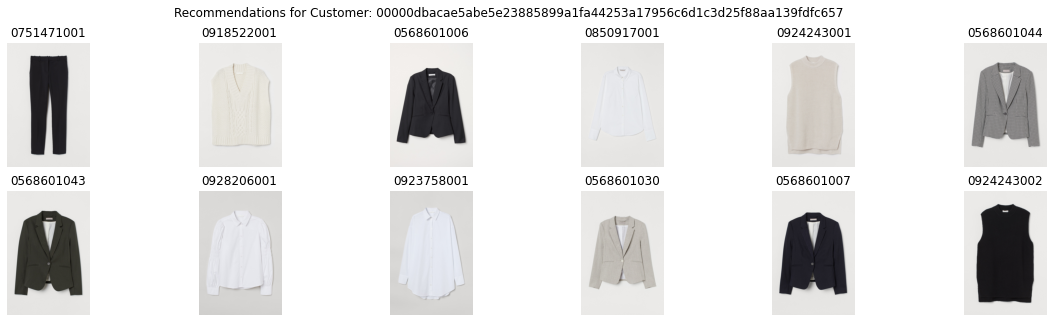

In [53]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Sample article_id list
article_ids = final_predictions[final_predictions['customer_id'] == customer_id]['article_id'].iloc[0].split()

# Setup image path root
image_root = '../input/h-and-m-personalized-fashion-recommendations/images'  # Replace with actual mount path if different

# Plot
plt.figure(figsize=(20, 5))
for i, article_id in enumerate(article_ids[:12]):
    img_path = os.path.join(image_root, f"{article_id[:3]}/{article_id}.jpg")
    try:
        img = Image.open(img_path)
        plt.subplot(2, 6, i+1)
        plt.imshow(img)
        plt.title(article_id)
        plt.axis('off')
    except:
        plt.subplot(2, 6, i+1)
        plt.text(0.5, 0.5, 'Image not found', ha='center', va='center')
        plt.axis('off')
plt.suptitle(f"Recommendations for Customer: {customer_id}")
plt.show()

